# Testing K nearest neigbours

Using the features file to separate into labels and features

In [46]:
import pandas as pd
import numpy as np

data = pd.read_csv('./util/feature_dataset.csv') 
data.fillna(0, inplace=True)
X = data[['border', 'asymmetry', 'Blue-gray', 'White', 'Black', 'Red', 'Light-brown', 'Dark-brown', 'Blue-gray']]


data['cancer'] = data['cancer'].astype(int)
y = data['cancer']
groups = data['patient_id']
unique_patients = data['patient_id'].unique()

Running cross-validation over different k values (get AUC)

In [47]:
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

#split data into training and test sets (by patient ID)
unique_patients = data['patient_id'].unique()
train_ids, test_ids = train_test_split(unique_patients, test_size=0.2, random_state=42)
train_idx = data['patient_id'].isin(train_ids)

X_train, y_train = X[train_idx], y[train_idx]
groups_train = groups[train_idx]

#standardScaler on training data (within pipeline below)
#GroupKFold CV with k from 3 to 10
cv = GroupKFold(n_splits=5)
k_values = range(1, 101, 2)
summary = []

for k in k_values:
    pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
    auc_scores = cross_val_score(pipe, X_train, y_train, cv=cv, groups=groups_train, scoring='roc_auc')
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    print(f"k={k}, AUC={mean_auc:.4f} ± {std_auc:.4f}")
    summary.append({'k': k, 'mean_auc': mean_auc, 'std_auc': std_auc})

summary_df = pd.DataFrame(summary)

k=1, AUC=0.5583 ± 0.0378
k=3, AUC=0.5897 ± 0.0369
k=5, AUC=0.5992 ± 0.0360
k=7, AUC=0.6016 ± 0.0405
k=9, AUC=0.6109 ± 0.0311
k=11, AUC=0.6109 ± 0.0265
k=13, AUC=0.6206 ± 0.0273
k=15, AUC=0.6300 ± 0.0341
k=17, AUC=0.6328 ± 0.0290
k=19, AUC=0.6365 ± 0.0334
k=21, AUC=0.6339 ± 0.0301
k=23, AUC=0.6403 ± 0.0283
k=25, AUC=0.6442 ± 0.0300
k=27, AUC=0.6441 ± 0.0302
k=29, AUC=0.6397 ± 0.0310
k=31, AUC=0.6412 ± 0.0332
k=33, AUC=0.6451 ± 0.0324
k=35, AUC=0.6439 ± 0.0337
k=37, AUC=0.6414 ± 0.0342
k=39, AUC=0.6404 ± 0.0350
k=41, AUC=0.6424 ± 0.0300
k=43, AUC=0.6449 ± 0.0301
k=45, AUC=0.6452 ± 0.0273
k=47, AUC=0.6447 ± 0.0281
k=49, AUC=0.6421 ± 0.0298
k=51, AUC=0.6393 ± 0.0314
k=53, AUC=0.6429 ± 0.0332
k=55, AUC=0.6403 ± 0.0338
k=57, AUC=0.6393 ± 0.0347
k=59, AUC=0.6408 ± 0.0344
k=61, AUC=0.6390 ± 0.0314
k=63, AUC=0.6403 ± 0.0314
k=65, AUC=0.6387 ± 0.0321
k=67, AUC=0.6384 ± 0.0337
k=69, AUC=0.6352 ± 0.0315
k=71, AUC=0.6327 ± 0.0318
k=73, AUC=0.6327 ± 0.0309
k=75, AUC=0.6352 ± 0.0328
k=77, AUC=0.6337 

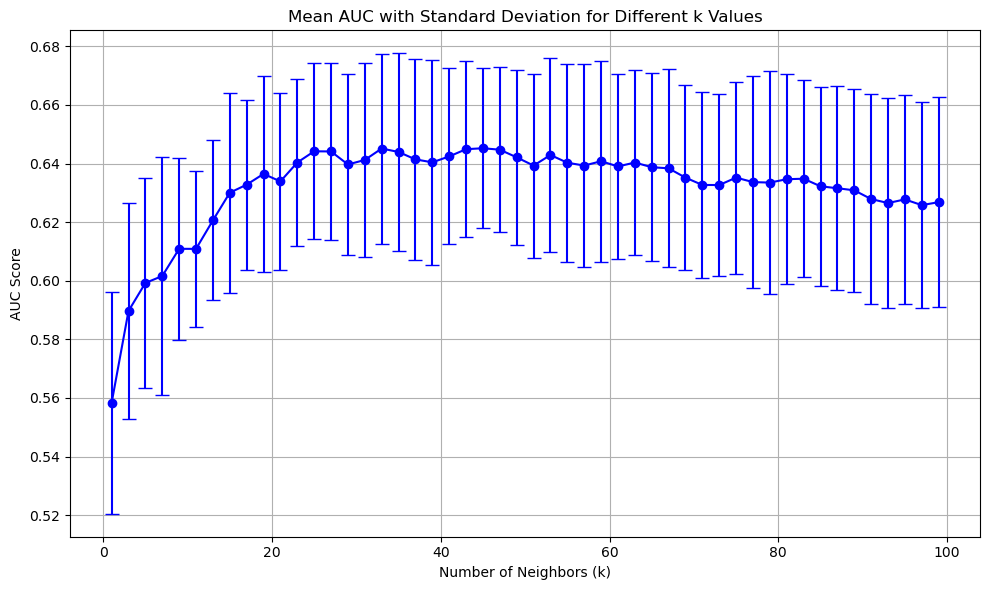

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.errorbar(summary_df['k'], summary_df['mean_auc'], yerr=summary_df['std_auc'], 
             fmt='-o', capsize=5, color='blue')
plt.title('Mean AUC with Standard Deviation for Different k Values')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('AUC Score')
plt.grid(True)
plt.tight_layout()
plt.show()

Chosing k=25 to train the model

In [49]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix
import pandas as pd
import numpy as np

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_ids], y[test_ids]
groups_train = groups[train_idx]
patient_ids_test = groups[test_ids]

# Fit final model on training data (best k = 50)
pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=25))
pipe.fit(X_train, y_train)

# Predict on test set
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]  # Probability of cancer

# Metrics
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)

print("Final Evaluation on Test Set:")
print(f"Accuracy: {acc:.4f}")
print(f"Recall: {rec:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion Matrix:")
print(cm)


results_df = pd.DataFrame({
    "patient_id": patient_ids_test.values,
    "true_label": y_test.values,
    "cancer_probability": y_prob
})
# results_df.to_csv("knn_final_test_probs.csv", index=False)

KeyError: "None of [Index(['PAT_452', 'PAT_516', 'PAT_264', 'PAT_180', 'PAT_1790', 'PAT_629',\n       'PAT_1699', 'PAT_394', 'PAT_1568', 'PAT_1090',\n       ...\n       'PAT_251', 'PAT_1728', 'PAT_460', 'PAT_1265', 'PAT_147', 'PAT_1761',\n       'PAT_307', 'PAT_76', 'PAT_2022', 'PAT_554'],\n      dtype='object', length=183)] are in the [columns]"

Checking features

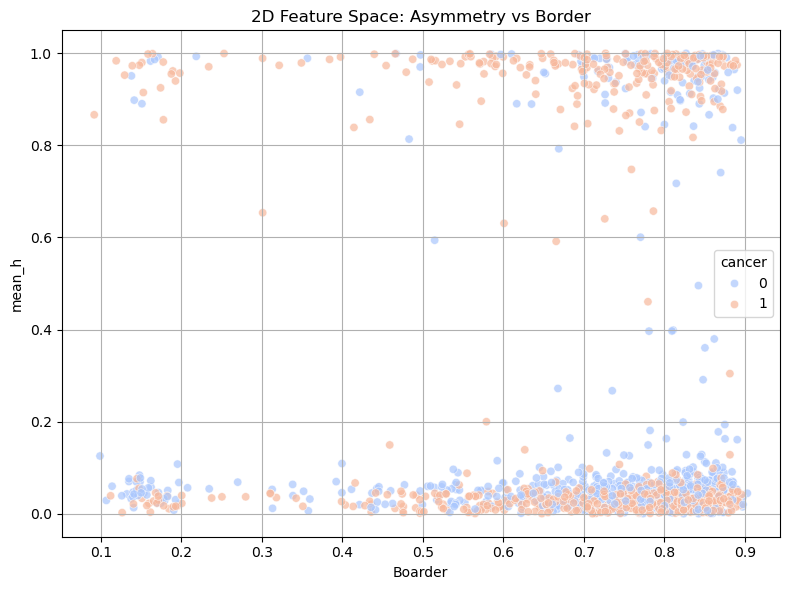

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data, 
    x='border', 
    y='mean_H', 
    hue='cancer', 
    palette='coolwarm', 
    alpha=0.7
)
plt.title("2D Feature Space: Asymmetry vs Border")
plt.xlabel("Boarder")
plt.ylabel("mean_h")
plt.grid(True)
plt.tight_layout()
plt.show()


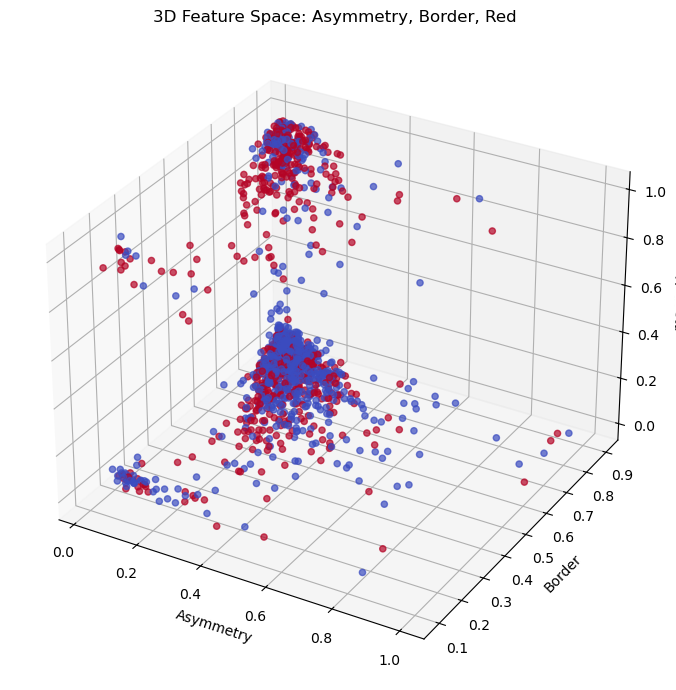

In [58]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot
ax.scatter(
    data['asymmetry'], 
    data['border'], 
    data['mean_H'], 
    c=data['cancer'], 
    cmap='coolwarm', 
    alpha=0.7
)

ax.set_title("3D Feature Space: Asymmetry, Border, Red")
ax.set_xlabel("Asymmetry")
ax.set_ylabel("Border")
ax.set_zlabel("mean_H")
plt.tight_layout()
plt.show()